# Loading the data.

In [40]:
import pandas as pd
import os

In [63]:
# Reading the data
root = r'/content/drive/MyDrive/CDIS Project/forecasting'
df = pd.read_excel(os.path.join(root, 'DEMAND_FILE.xlsx'),
                    sheet_name= 'Daily CGD Volume - Ahmedabad')

df = df.iloc[0:3,:] # Droping unwanted coloumns
df = df.T # Transposing the df to have the different dates as rows.
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)

df['Date'] = df['Date'].astype('str').str.split().str[0] # Removing time from the Date coloumn.
df['Date'] = pd.to_datetime(df['Date']) # Converting Date to DateTime
df = df.rename(columns={'CNG Sales Ahmedabad (SCM/day)': 'Sales'})
df['Sales'] = df['Sales'].astype('float64')
df.columns.name = None

# Adding day and date info
import calendar
def days_in_month(row):
    return calendar.monthrange(row['Year'], row['Month'])[1]

df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfYear'] = df['Date'].dt.dayofyear
df['IsWeekend'] = (df['Weekday'] >= 5).astype(int)
df['DaysInMonth'] = df.apply(days_in_month, axis=1)

# Applying Cyclical Encoding
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / df['DaysInMonth'])
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / df['DaysInMonth'])

df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

df['Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
df['Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)

df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)

# Drop raw columns if necessary
df = df.drop(columns=['Weekday', 'Month', 'DayOfYear', 'DaysInMonth','Day','Year'])
df

,Date,Sales,IsWeekend,Day_sin,Day_cos,Month_sin,Month_cos,Weekday_sin,Weekday_cos,DayOfYear_sin,DayOfYear_cos
0,2023-04-01,489076.113688,1,2.079117e-01,0.978148,8.660254e-01,-0.5,-0.974928,-0.222521,9.999907e-01,0.004304
1,2023-04-02,491107.744591,1,4.067366e-01,0.913545,8.660254e-01,-0.5,-0.781831,0.623490,9.999167e-01,-0.012910
2,2023-04-03,463311.399700,0,5.877853e-01,0.809017,8.660254e-01,-0.5,0.000000,1.000000,9.995463e-01,-0.030120
3,2023-04-04,456306.343200,0,7.431448e-01,0.669131,8.660254e-01,-0.5,0.781831,0.623490,9.988797e-01,-0.047321
4,2023-04-05,493338.999138,0,8.660254e-01,0.500000,8.660254e-01,-0.5,0.974928,-0.222521,9.979172e-01,-0.064508
...,...,...,...,...,...,...,...,...,...,...,...
270,2023-12-27,571390.999704,0,-7.247928e-01,0.688967,-2.449294e-16,1.0,0.974928,-0.222521,-6.880243e-02,0.997630
271,2023-12-28,576890.976666,0,-5.712682e-01,0.820763,-2.449294e-16,1.0,0.433884,-0.900969,-5.161967e-02,0.998667
272,2023-12-29,572104.814138,0,-3.943559e-01,0.918958,-2.449294e-16,1.0,-0.433884,-0.900969,-3.442161e-02,0.999407
273,2023-12-30,585843.459244,1,-2.012985e-01,0.979530,-2.449294e-16,1.0,-0.974928,-0.222521,-1.721336e-02,0.999852


In [64]:
train_size = (int)(0.8*len(df))
train_df, test_df = df[:train_size], df[train_size:]

# Plotting the data.

**Plotting train data**

In [66]:
import plotly.express as px
fig = px.line(x=train_df['Date'], y=train_df['Sales'])
fig.show()

**Plotting test data.**

In [67]:
fig = px.line(x=test_df['Date'], y=test_df['Sales'])
fig.show()

# Training the model.

In [68]:
prophet_train_df = train_df.copy()
prophet_test_df = test_df.copy()

In [69]:
prophet_train_df.columns

Index(['Date', 'Sales', 'IsWeekend', 'Day_sin', 'Day_cos', 'Month_sin',
       'Month_cos', 'Weekday_sin', 'Weekday_cos', 'DayOfYear_sin',
       'DayOfYear_cos'],
      dtype='object')

In [94]:
from prophet import Prophet

model = Prophet()
# model.add_country_holidays(country_name='India')
for reg in prophet_train_df.columns[2:]:
  model.add_regressor(reg)

prophet_train_df.rename(columns={'Date':'ds',
                                 'Sales':'y'},inplace=True)
model.fit(prophet_train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6pkp38z8/jf9c14pz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6pkp38z8/_hrdwhmt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35197', 'data', 'file=/tmp/tmp6pkp38z8/jf9c14pz.json', 'init=/tmp/tmp6pkp38z8/_hrdwhmt.json', 'output', 'file=/tmp/tmp6pkp38z8/prophet_modelcc73wkmx/prophet_model-20250218072622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:26:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:26:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


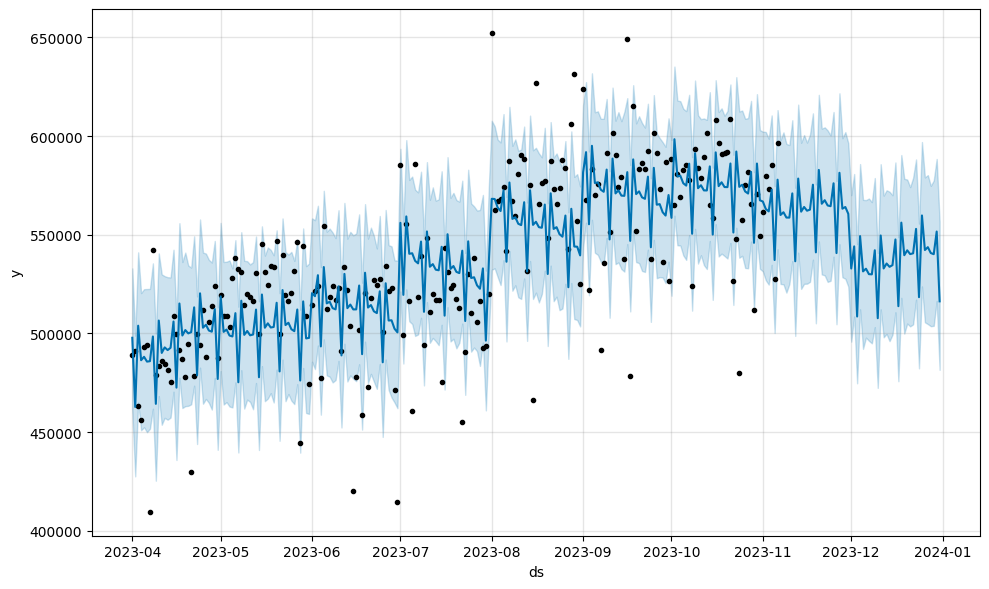

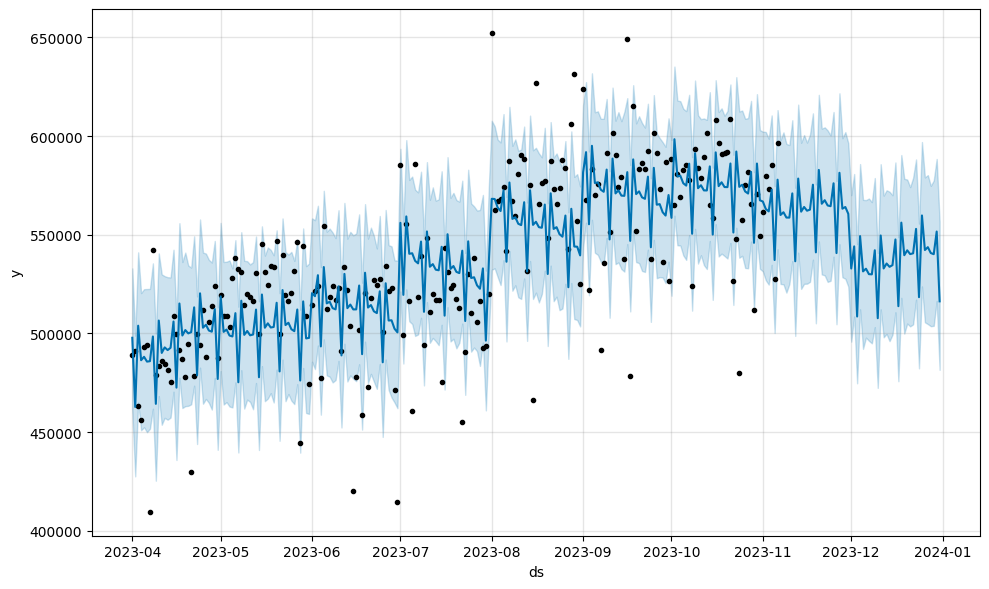

In [95]:
# Create a DataFrame for future dates
future = model.make_future_dataframe(periods=len(prophet_test_df), freq='1D')
for reg in prophet_test_df.columns[2:]:
  future[reg] = prophet_train_df[reg].to_list() + prophet_test_df[reg].to_list()

# Make predictions
forecast = model.predict(future )
# Plot the forecast
model.plot(forecast)

In [96]:
from sklearn.metrics import mean_absolute_error
from sktime.performance_metrics.forecasting import median_absolute_percentage_error, mean_absolute_percentage_error

test_predictions = forecast.iloc[-len(prophet_test_df):]['yhat']
test_actual = prophet_test_df['Sales']

# Calculate MAE
mae = mean_absolute_percentage_error(test_actual, test_predictions)
median_absolute_percentage_error = median_absolute_percentage_error(test_actual, test_predictions)
print(f"Mean Absolute Percentage Error (MAE): {mae}")
print(f"Median Absolute Percentage Error: {median_absolute_percentage_error}")

Mean Absolute Percentage Error (MAE): 0.08892018969001558
Median Absolute Percentage Error: 0.07472472105540492
